<a href="https://colab.research.google.com/github/Vivek084c/From_Scratch/blob/main/siglip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L http://i.imgur.com/8o9DXSj.jpeg --output image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44094  100 44094    0     0   256k      0 --:--:-- --:--:-- --:--:--  256k


In [2]:
!nvidia-smi

Fri Feb 28 19:29:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

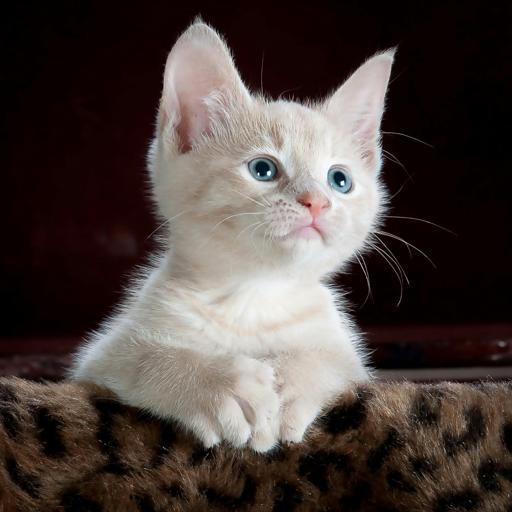

In [3]:
from PIL import Image

img = Image.open("image.jpg")
img

In [9]:
# importing the libraries
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig


In [10]:
# we are using 224 by 224 images
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
#getting the complete model along with weights
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

vision_model

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

## preprocessing the image so that the model can process it

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass


from torchvision import transforms

def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image_tensor = preprocess(image)
    #(3, 224, 224) --> unsqueeze --> (1, 3, 224, 224)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

image_tensor = preprocess_image(img)

#config used by the model
embed_dim = 768 #defining the embedding
patch_size = 16  # each piece of the image is 16*16 pixel
image_size = 224
num_of_pathches = (image_size // path_size) **2 # no of individual piece of the image

#we dont have gradient here
with torch.no_grad():
  patch_embeddings = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size = patch_size, stride = patch_size)
  patches = patch_embeddings(image_tensor)

patches.shape, num_of_pathches



(torch.Size([1, 768, 14, 14]), 196)

In [19]:
# geenrating the postion embedding
position_embedding = nn.Embedding(num_of_pathches, embed_dim)
print("postion embeddings : \n")
print(position_embedding)

position_ids = torch.arange(num_of_pathches).expand((1, -1))
print("position_ids : \n")
print(position_ids)

print("position_ids shape : \n")
position_ids.shape

postion embeddings : 

Embedding(196, 768)
position_ids : 

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 16

torch.Size([1, 196])

In [25]:
embeddings.shape

torch.Size([1, 196, 768])

In [28]:
position_embedding

Embedding(196, 768)

#adding the path embedding with the position embedding


In [20]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) -> (1, 196, 768)
embeddings = embeddings.transpose(1,2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])

## visualising the embeddings

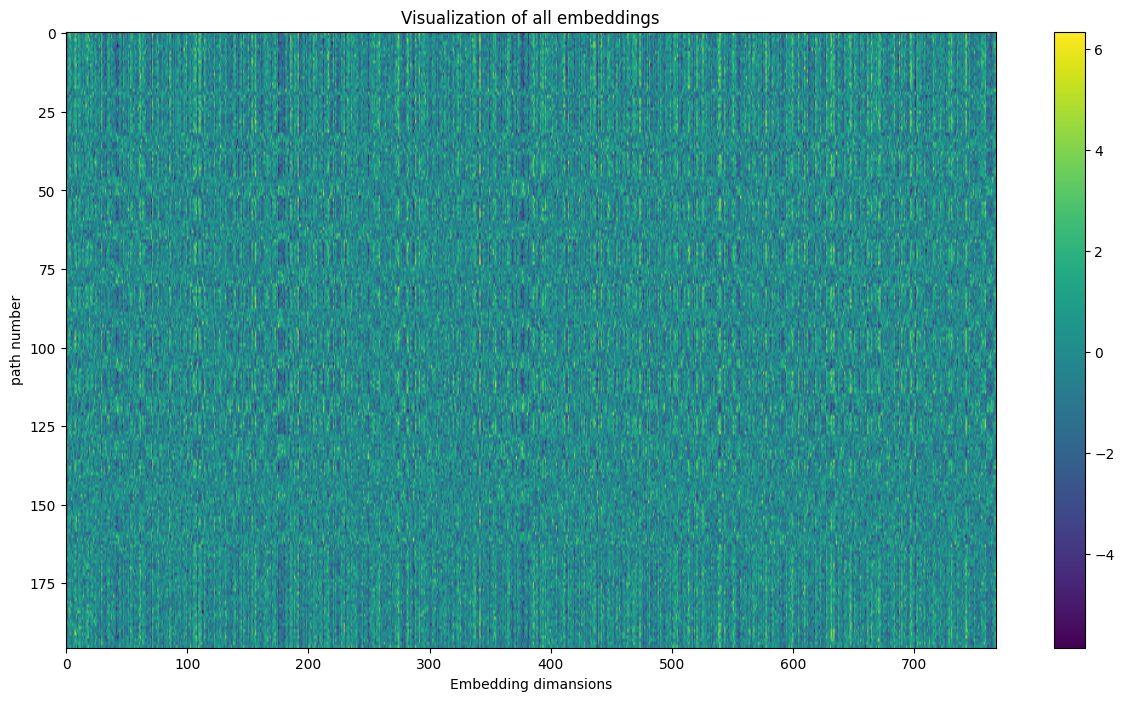

In [30]:
import matplotlib.pyplot as plt

patch_vis = embeddings[0].detach().numpy() # shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patch_vis, aspect = "auto", cmap="viridis")
plt.colorbar()

plt.title("Visualization of all embeddings")
plt.xlabel("Embedding dimansions")
plt.ylabel("path number")
plt.show()


# comparing to the trained embeddings

torch.Size([1, 196, 768])


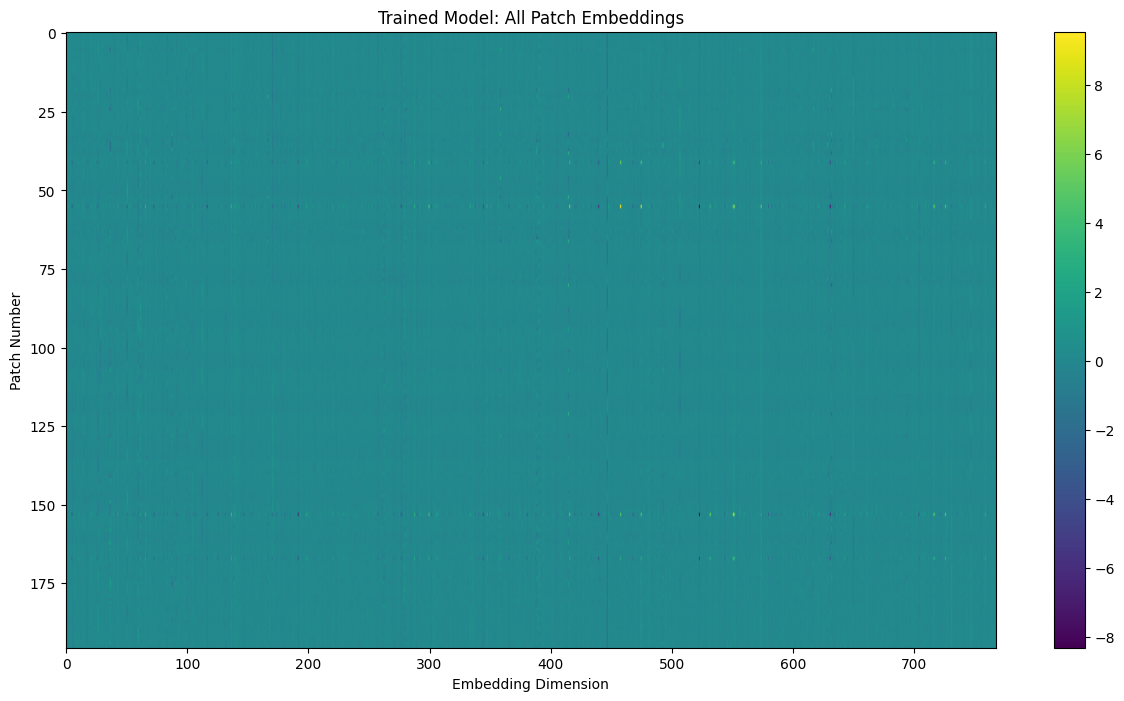

In [31]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trained Model: All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()